# LightGBM

In [83]:
import pandas as pd
import numpy as np
from numpy import sqrt
import lightgbm as lgb
from numpy import argmax
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

## Dataframes

In [84]:
df_public = pd.read_csv('dados/public.csv')
df_metar = pd.read_csv('dados/metar.csv', index_col=0, low_memory=False)

## Tratamento

In [85]:
# variáveis para junção
df_public['data_ref'] = df_public['hora_ref'].apply(lambda x: x[:7])
df_metar['date'] = df_metar['date'].apply(lambda x: x[:7])

In [86]:
df_model = df_public.merge(df_metar, how='left', left_on=['metar', 'data_ref'], right_on=['meta', 'date'])

In [87]:
# variáveis de data
df_model['ano'] = np.int64(df_model['hora_ref'].str[:4])
df_model['mes'] = np.int64(df_model['hora_ref'].str[5:7])
df_model['dia'] = np.int64(df_model['hora_ref'].str[8:10])
df_model['hora'] = np.int64(df_model['hora_ref'].str[11:13])

# variáveis categóricas
df_model['origem'] = df_model['origem'].astype('category')
df_model['destino'] = df_model['destino'].astype('category')

cat_columns = df_model.select_dtypes(['category']).columns
df_model[cat_columns] = df_model[cat_columns].apply(lambda x: x.cat.codes)

## Variáveis

In [88]:
df_model = df_model[[
    'ano',
    'mes',
    'dia',
    'hora',
    'origem',
    'destino',
    'prev_troca_cabeceira',
    'troca_cabeceira_hora_anterior',
    'espera',
    'latitude',
    'longitude',
    'elevation',
    'wind_direction',
    'wind_speed',
    'visibility',
    'low_cloud_level',
    'cloud_coverage',
    'air_temperature',
    'dew_point_temperature',
    'altimeter',
    'current_wx1_symbol',
    'current_wx2_symbol',
    'current_wx3_symbol',
    'air_pressure_at_sea_level',
    'eastward_wind',
    'northward_wind'
]]

## Datasets de Treino e Teste

In [89]:
# Dataframe para envio na competição
df_test_final = df_model[df_model.espera.isnull()].drop('espera',axis=1)

# Dataframes de treino e teste
df_train_inicial = df_model[~df_model.espera.isnull()]
X_train_inicial = df_train_inicial.drop('espera', axis=1)
y_train_inicial = df_train_inicial['espera']

X_train, X_test, y_train, y_test = train_test_split(
    X_train_inicial, y_train_inicial, test_size=0.20, random_state=42, stratify=y_train_inicial)

In [90]:
train_data_lgb = lgb.Dataset(X_train, label=y_train, categorical_feature=['origem','destino','prev_troca_cabeceira','troca_cabeceira_hora_anterior'], free_raw_data = False)
validation_data_lgb = lgb.Dataset(X_test, label=y_test, categorical_feature=['origem','destino','prev_troca_cabeceira','troca_cabeceira_hora_anterior'], free_raw_data = False)

## Parâmetros

In [91]:
# param = {'num_leaves': 31, 'objective': 'binary', 'metric': 'auc'}

In [92]:
space={'num_leaves': hp.quniform("num_leaves", 5, 40, 1),
        'max_depth' : hp.quniform('max_depth', -1, 15, 1),
        'learning_rate': hp.uniform('learning_rate', 0.1,  1),
        'treshold': hp.uniform('treshold', 0.033,  0.1),
        'num_round': hp.quniform("num_round", 3, 24, 1),
    }

In [93]:
# Classifier:
def hyperparameter_tuning(space):

    param = {
        'num_leaves': int(space['num_leaves']),
        'max_depth': int(space['max_depth']),
        'learning_rate': space['learning_rate'],
        'objective': 'binary',
        'metric': 'auc',
        'verbosity':-1
        }
    num_round = int(space['num_round'])
    model = lgb.train(param, train_data_lgb, num_round,valid_sets=[validation_data_lgb])

    pred = model.predict(X_test, num_iteration=model.best_iteration)
    auc_w_threshold = roc_auc_score(y_test, pred>space['treshold'])
    auc = roc_auc_score(y_test, pred)

    print('Atrasados: ' + str((pred>space['treshold']).sum()) + ' || '+ "AUC: " + str(auc) + ' || ' + 'AUC WITH THRESHOLD: ' + str(auc_w_threshold))
    #change the metric if you like
    return {'loss': 1 - auc_w_threshold, 'status': STATUS_OK, 'model': model}

In [94]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=11354,
            trials=trials)
print(best)

  0%|          | 0/11354 [00:00<?, ?trial/s, best loss=?]

Atrasados: 700 || AUC: 0.7872557081547109 || AUC WITH THRESHOLD: 0.5999862908978836
Atrasados: 1675 || AUC: 0.7584027614169699 || AUC WITH THRESHOLD: 0.6062188440431604
Atrasados: 855 || AUC: 0.769055676404913 || AUC WITH THRESHOLD: 0.5732672247790113 
Atrasados: 717 || AUC: 0.8045758360424005 || AUC WITH THRESHOLD: 0.5921870577791196
Atrasados: 2348 || AUC: 0.7744940442709082 || AUC WITH THRESHOLD: 0.6174621832803555
Atrasados: 1346 || AUC: 0.7436220139280956 || AUC WITH THRESHOLD: 0.5791032153177411
Atrasados: 1430 || AUC: 0.7633935693384237 || AUC WITH THRESHOLD: 0.5974260516582321
Atrasados: 1350 || AUC: 0.6883646776421897 || AUC WITH THRESHOLD: 0.5535086511023074
Atrasados: 1469 || AUC: 0.7754964428582084 || AUC WITH THRESHOLD: 0.5831483789647249
Atrasados: 2181 || AUC: 0.7768983885460925 || AUC WITH THRESHOLD: 0.6173981063564733
Atrasados: 633 || AUC: 0.7263742477892645 || AUC WITH THRESHOLD: 0.5517699631582965 
Atrasados: 1747 || AUC: 0.7149350572466728 || AUC WITH THRESHOLD: 0.

## Treino

In [95]:
param = {'num_leaves': 37, 'objective': 'binary', 'metric': 'auc', 'learning_rate':'0.132740500540073', 'max_depth': 7}
num_round = 23
bst = lgb.train(param, train_data_lgb, num_round, valid_sets=[validation_data_lgb])

[LightGBM] [Info] Number of positive: 2949, number of negative: 166394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1473
[LightGBM] [Info] Number of data points in the train set: 169343, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017414 -> initscore=-4.032892
[LightGBM] [Info] Start training from score -4.032892


## Teste

In [96]:
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

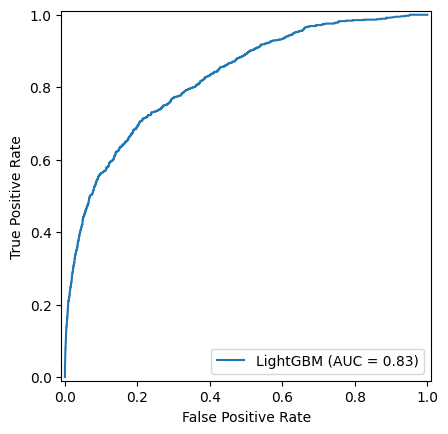

In [97]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='LightGBM')
display.plot()
plt.show()

## Otimização do Threshold Probabilístico

### ROC

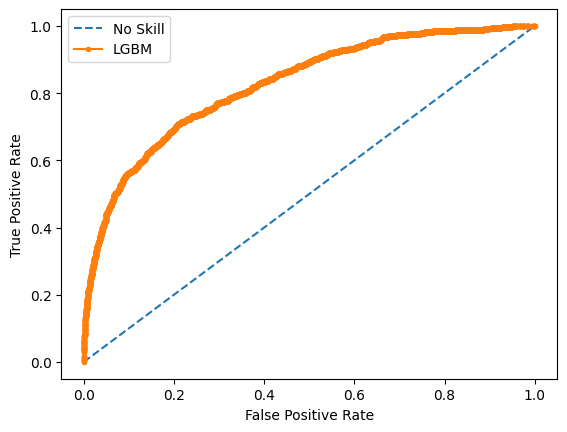

In [98]:
# calcula a curva
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# grafico 
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LGBM')

# titulos
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [99]:
# calcula o melhor ponto 
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.021435, G-Mean=0.749


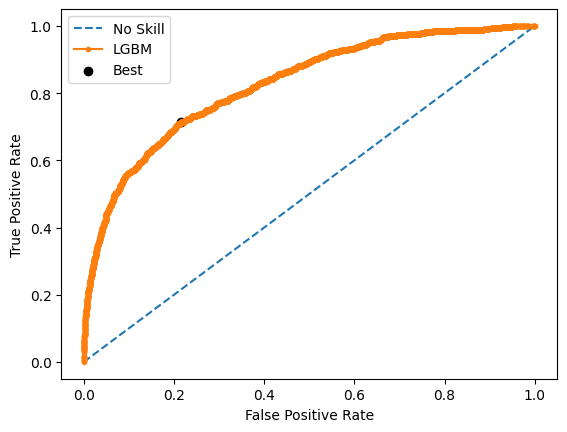

In [100]:
# plota o melhor ponto
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LGBM')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# titulos
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

### PRC

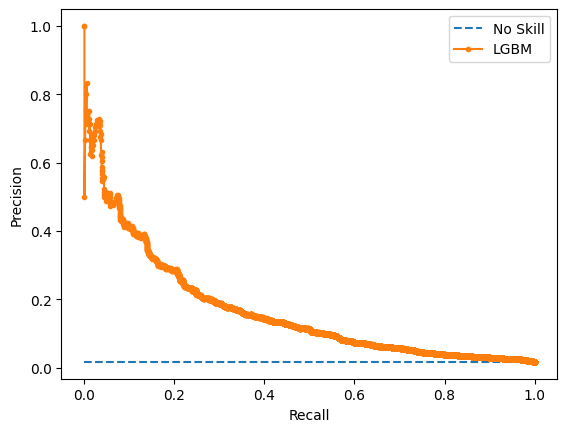

In [101]:
# calcula a curva
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# grafico 
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='LGBM')

# titulos
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.show()

In [102]:
# medida F
fscore = (2 * precision * recall) / (precision + recall + 0.00001)

# índice do maior F
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.114127, F-Score=0.240


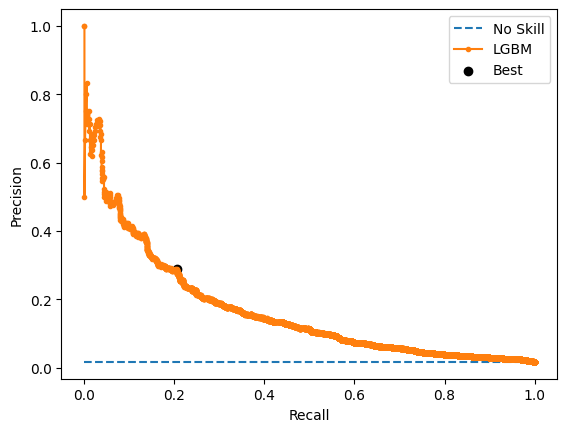

In [103]:
# plota o melhor ponto
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='LGBM')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

# titulos
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.show()

## Submissão

In [111]:
# ids
sub = df_public[df_public.espera.isnull()].drop('espera',axis=1).flightid

# threshold escolhido
threshold = 0.055

# submissao
sub = pd.DataFrame(sub)
y_pred_final = bst.predict(df_test_final)
sub['espera'] = np.int8(y_pred_final > threshold)

# informacoes
print(f'Métrica F1 na validação: {f1_score(y_test, np.int8(y_pred > threshold))}')
print(f'{sub.espera.sum()} de {sub.shape[0]} voos classificados como atrasados com threshold {threshold}')


sub.to_csv('submissions/submission_lightgbm.csv', index=False)

Métrica F1 na validação: 0.21559633027522937
3571 de 90720 voos classificados como atrasados com threshold 0.055
